In [1]:
import pandas as pd
import numpy as np
import os
import random
import scipy as sp
from sklearn.metrics import confusion_matrix 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Import Files

In [5]:
n = 5819078 
skip = random.sample(range(1,n),n-20000) 
flights = pd.read_csv("G:/Mini-Minor project bvcoe/flights.csv",skiprows=skip,usecols = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE',
                                                             'DEPARTURE_DELAY','ARRIVAL_DELAY','CANCELLED'],low_memory=False) 
airports = pd.read_csv("G:/Mini-Minor project bvcoe/airports.csv")
airlines = pd.read_csv("G:/Mini-Minor project bvcoe/airlines.csv") 
flights = flights.sample(frac=1).reset_index(drop=True) 
all_features = flights.columns.values  

## Fixing Airport Data

In [6]:
import io
import requests

url1 = "https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT"
s1 = requests.get(url1).content
url2 = "https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID"
s2 = requests.get(url2).content

aircode1 = pd.read_csv(io.StringIO(s1.decode('utf-8')))
aircode2 = pd.read_csv(io.StringIO(s2.decode('utf-8')))

#aircode1 = pd.DataFrame.from_csv('L_AIRPORT.csv')
#aircode2 = pd.DataFrame.from_csv('L_AIRPORT_ID.csv')


# Format the airport codes
aircode1 = aircode1.reset_index()
aircode2 = aircode2.reset_index()
aircodes = pd.merge(aircode1,aircode2,on='Description')
aircode_dict = dict(zip(aircodes['Code_y'].astype(str),aircodes['Code_x']))

# Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)
for i in range(len(flights)):
    if len(flights['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = flights['ORIGIN_AIRPORT'][i]
        value = aircode_dict[flights['ORIGIN_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)
for i in range(len(flights)):
    if len(flights['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = flights['DESTINATION_AIRPORT'][i]
        value = aircode_dict[flights['DESTINATION_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)

## Enter the name of the Airport

In [4]:
Depart_airport = str(input("Specify the departure airport (three letters) or put ALL:  ")).upper()
if Depart_airport in list(flights['ORIGIN_AIRPORT']):
    flights = flights[flights['ORIGIN_AIRPORT']== Depart_airport]
elif Depart_airport == 'ALL':
    print('Analyzing all airports')
else:        
    print("incorrect airport code")
#flights = flights[flights['ORIGIN_AIRPORT']=='LAS']

Specify the departure airport (three letters) or put ALL:  ALL
Analyzing all airports


## Describing whether the flight was late or cancelled

In [7]:
def late_or_cancelled(x):
#    if x['ARRIVAL_DELAY'] > 60:
    if x['CANCELLED'] == 1 or x['ARRIVAL_DELAY'] > 60:
        return 1
    else:
        return 0

flights['late or cancelled'] = flights.apply(late_or_cancelled,axis = 1)
flights = flights[flights['CANCELLED']==0]
#predictions = flights.apply(late_or_cancelled,axis = 1)

In [8]:
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
def day_31_to_365(x):
    days_365 = days_in_month[:x['MONTH']-1].sum() + x['DAY']
    return days_365

## calculating number of weeks instead of month

In [9]:
flights['DAY'] = flights.apply(day_31_to_365,axis = 1)
flights['WEEK'] = flights['DAY']//7
del flights['DAY']

In [10]:
flights['SCHEDULED_DEPARTURE'] = np.ceil(flights['SCHEDULED_DEPARTURE']/600).apply(int)

## delete unnecessary data

In [11]:
del flights['ARRIVAL_DELAY']
del flights['DEPARTURE_DELAY']
del flights['CANCELLED']

## Plot being late or not vs other features

In [12]:
Delay_vs_Day_of_Week = pd.DataFrame({'delays' : flights.groupby(['DAY_OF_WEEK'])['late or cancelled'].mean()}).reset_index()
Delay_vs_WEEK = pd.DataFrame({'delays' : flights.groupby(['WEEK'])['late or cancelled'].mean()}).reset_index()
Delay_vs_AIRLINE = pd.DataFrame({'delays' : flights.groupby(['AIRLINE'])['late or cancelled'].mean()})#.reset_index()
Delay_vs_SCHEDULED_DEPARTURE = pd.DataFrame({'delays' : flights.groupby(['SCHEDULED_DEPARTURE'])['late or cancelled'].mean()}).reset_index()

#Delay_vs_Day_of_Week.plot(x='DAY_OF_WEEK', y='delays')
#Delay_vs_Day_of_Week['delays'].hist(hold=None)

[Text(0, 0, '00:00 - 06:00'),
 Text(0, 0, '06:00 - 12:00'),
 Text(0, 0, '12:00 - 18:00'),
 Text(0, 0, '18:00 - 00:00')]

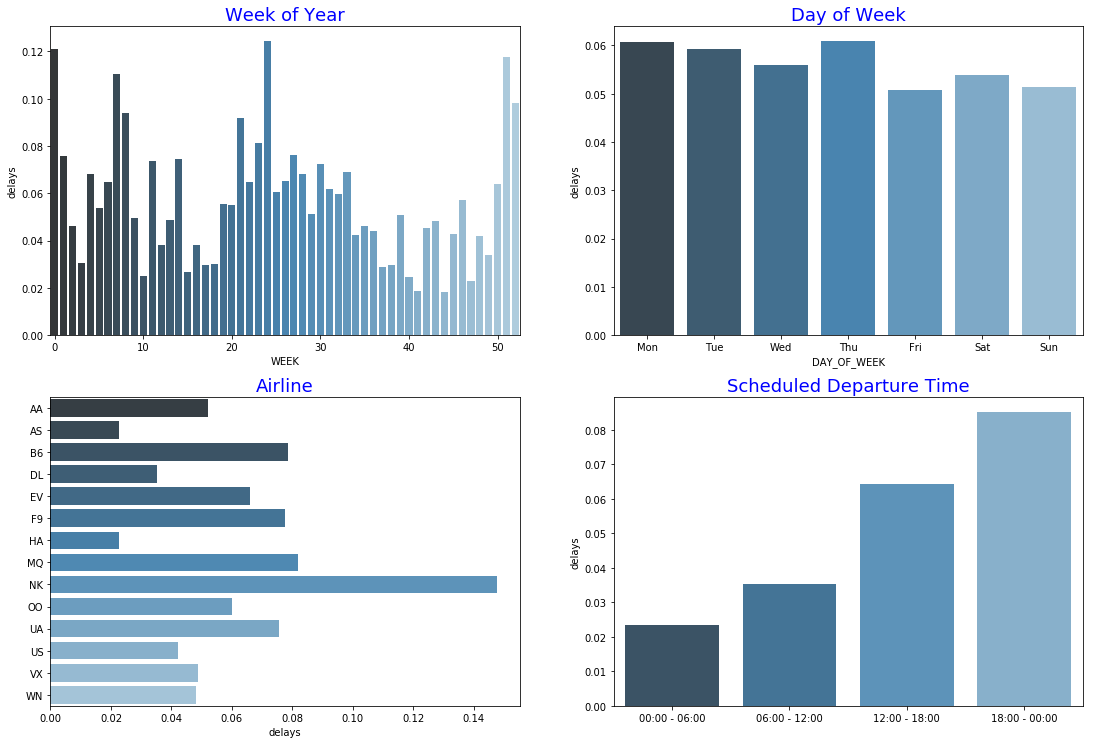

In [13]:
fig = plt.figure(figsize=(18.5, 12.5))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('Week of Year', fontsize=18, color="blue")
sns.barplot(x="WEEK", y="delays", data=Delay_vs_WEEK, palette="Blues_d", ax = sub1)
sub1.set_xticks(list(range(0,52,10)))
sub1.set_xticklabels(list(range(0,52,10)))

sub2 = fig.add_subplot(222)
sub2.set_title('Day of Week', fontsize=18, color="blue")
sns.barplot(x="DAY_OF_WEEK", y="delays", data=Delay_vs_Day_of_Week, palette="Blues_d", ax = sub2)
sub2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

sub3 = fig.add_subplot(223)
sub3.set_title('Airline', fontsize=18, color="blue")
sns.barplot(y = list(range(len(Delay_vs_AIRLINE))), x=Delay_vs_AIRLINE['delays'], palette="Blues_d", ax = sub3, orient="h")
sub3.set_yticks(range(len(Delay_vs_AIRLINE)))
sub3.set_yticklabels(Delay_vs_AIRLINE.index)

sub4 = fig.add_subplot(224)
sns.barplot(x = list(range(len(Delay_vs_SCHEDULED_DEPARTURE))), y=Delay_vs_SCHEDULED_DEPARTURE['delays'], palette="Blues_d", ax = sub4)
sub4.set_title('Scheduled Departure Time', fontsize=18, color="blue")
sub4.set_xticks([0, 1, 2, 3])
sub4.set_xticklabels(['00:00 - 06:00','06:00 - 12:00','12:00 - 18:00','18:00 - 00:00'])

## Correcting for a bias in being late vs not being late

In [14]:
num_late = sum(flights['late or cancelled'])

flights_on_time = flights[flights['late or cancelled']==0]

flights_orig = flights.copy()

flights_on_time = flights_on_time.sample(frac=num_late/flights.shape[0]).reset_index(drop=True)
flights_on_time.shape
flights = pd.concat([flights[flights['late or cancelled']==1],flights_on_time])
flights = flights.sample(frac=1).reset_index(drop=True)


## Converting categorical values to sparce matrixes

In [15]:
from sklearn.preprocessing import LabelBinarizer

WEEK_LabBin = LabelBinarizer()
WEEK_LabBin.fit(flights_orig['WEEK'])
WEEK_binarized = np.array(WEEK_LabBin.transform(flights['WEEK']))
WEEK_binarized_orig = np.array(WEEK_LabBin.transform(flights_orig['WEEK']))


DAY_OF_WEEK_LabBin = LabelBinarizer()
DAY_OF_WEEK_LabBin.fit(flights_orig['DAY_OF_WEEK'])
DAY_OF_WEEK_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['DAY_OF_WEEK']))
DAY_OF_WEEK_binarized_orig = np.array(DAY_OF_WEEK_LabBin.transform(flights_orig['DAY_OF_WEEK']))


AIRLINE_LabBin = LabelBinarizer()
AIRLINE_LabBin.fit(flights_orig['AIRLINE'])
AIRLINE_binarized = np.array(AIRLINE_LabBin.transform(flights['AIRLINE']))
AIRLINE_binarized_orig = np.array(AIRLINE_LabBin.transform(flights_orig['AIRLINE']))


ORIGIN_AIRPORT_LabBin = LabelBinarizer()
ORIGIN_AIRPORT_LabBin.fit(flights_orig['ORIGIN_AIRPORT'])
ORIGIN_AIRPORT_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['ORIGIN_AIRPORT']))
ORIGIN_AIRPORT_binarized_orig = np.array(DAY_OF_WEEK_LabBin.transform(flights_orig['ORIGIN_AIRPORT']))


DESTINATION_AIRPORT_LabBin = LabelBinarizer()
DESTINATION_AIRPORT_LabBin.fit(flights_orig['DESTINATION_AIRPORT'])
DESTINATION_AIRPORT_binarized = np.array(DESTINATION_AIRPORT_LabBin.transform(flights['DESTINATION_AIRPORT']))
DESTINATION_AIRPORT_binarized_orig = np.array(DESTINATION_AIRPORT_LabBin.transform(flights_orig['DESTINATION_AIRPORT']))


SCHEDULED_DEPARTURE_LabBin = LabelBinarizer()
SCHEDULED_DEPARTURE_LabBin.fit(flights_orig['SCHEDULED_DEPARTURE'])
SCHEDULED_DEPARTURE_binarized = np.array(SCHEDULED_DEPARTURE_LabBin.transform(flights['SCHEDULED_DEPARTURE']))
SCHEDULED_DEPARTURE_binarized_orig = np.array(SCHEDULED_DEPARTURE_LabBin.transform(flights_orig['SCHEDULED_DEPARTURE']))


# flights_binarized will contain all data in sparce matrix form
flights_binarized = np.concatenate((WEEK_binarized,DAY_OF_WEEK_binarized,AIRLINE_binarized,ORIGIN_AIRPORT_binarized,
                                    DESTINATION_AIRPORT_binarized,SCHEDULED_DEPARTURE_binarized),axis=1)
flights_binarized_orig = np.concatenate((WEEK_binarized_orig,DAY_OF_WEEK_binarized_orig,AIRLINE_binarized_orig,ORIGIN_AIRPORT_binarized_orig,
                                    DESTINATION_AIRPORT_binarized_orig,SCHEDULED_DEPARTURE_binarized_orig),axis=1)

print(flights_binarized.shape)
print(flights_binarized_orig.shape)

(2154, 386)
(19702, 386)


## Split data into training and test data

In [16]:
# splitting data into test and training sets
from sklearn.model_selection import train_test_split

train_set, test_set, train_set_target, test_set_target = train_test_split(flights_binarized, flights['late or cancelled'], test_size = 0.4, random_state=42)

## Random Forest 

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(train_set,train_set_target)

C:\Users\Anusha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
confusion_matrix(train_set_target,(forest_reg.predict(train_set)).round())

array([[628,   4],
       [ 23, 637]], dtype=int64)

In [19]:
confusion_matrix(test_set_target,(forest_reg.predict(test_set)).round())

array([[265, 149],
       [201, 247]], dtype=int64)

## Grid Search for Random Forest

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [75, 100],'max_features':[10, 20],'max_depth':[20, 30]}]
forest_reg = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_set,train_set_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [75, 100], 'max_features': [10, 20], 'max_depth': [20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [77]:
import pickle

data = 'data.json'
pickle.dump(grid_search, open(data, 'wb'))
with open('data.json', 'wb') as f:
    pickle.dump(data, f)

bytes_sequence = pickle.dumps(data)
data = pickle.loads(bytes_sequence)


import json
with open('data.json', 'w') as f:
    json.dump(data, f)


with open('data.json', 'r') as f:
    data = json.load(f)
    
json_string = json.dumps(data)
data = json.loads(json_string)



In [79]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

ModuleNotFoundError: No module named 'tensorflow'

In [67]:
import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow.python.framework import device as tfdev


from keras.utils.visualize_util import to_graph
from keras.models import Sequential
to_graph(Sequential())

model = Sequential()
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

ModuleNotFoundError: No module named 'tensorflow'

In [69]:
json_file = model.to_json()
with open('data.json', "w") as
file:
    file.write(json_file)
    
model.save_weights(h5_file)

SyntaxError: invalid syntax (<ipython-input-69-2e736b2df0ad>, line 2)

In [19]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(grid_search, open(filename, 'wb'))



## Confusion Matrix for Training Data

In [20]:
# confusion matrix for training set
confusion_matrix(train_set_target,(grid_search.predict(train_set)).round())

array([[604,  16],
       [  7, 659]], dtype=int64)

In [21]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

## Confusion Matrix for Test Data

In [22]:
# confusion matrix for test set
confusion_matrix(test_set_target,(grid_search.predict(test_set)).round())


array([[220, 201],
       [142, 295]], dtype=int64)

## column "Comparison" to show which results is true/false pos/neg

### True pos = 1, True neg = 2, False pos = 3, false neg = 4

In [23]:
def comparison_col(x):
    # True pos = 1, True neg = 2, False pos = 3, false neg = 4
    if (x['True'] == 1) & (x['predict'] > 0.5):
        return 1
    elif (x['True'] == 0) & (x['predict'] < 0.5):
        return 2
    elif (x['True'] == 0) & (x['predict'] > 0.5):
        return 3
    elif (x['True'] == 1) & (x['predict'] < 0.5):
        return 4

In [24]:
predictions = grid_search.predict(train_set)
grid_reg_results = pd.DataFrame({'True':train_set_target, 'predict':predictions})

grid_reg_results['Comparison'] = grid_reg_results.apply(comparison_col, axis = 1)

(0, 1)

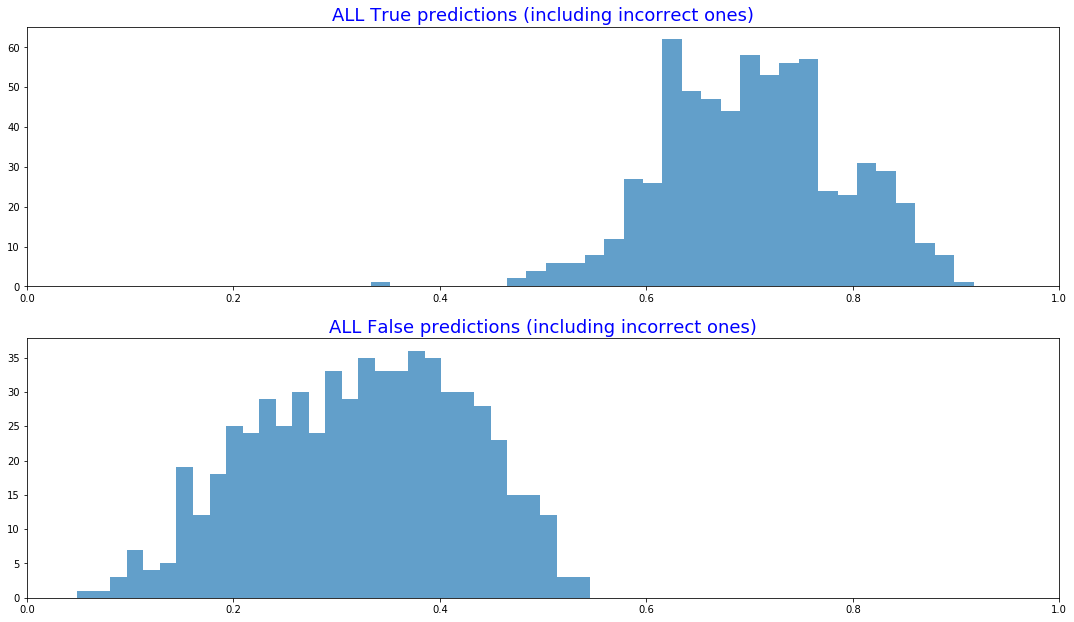

In [25]:
fig = plt.figure(figsize=(18.5, 10.5))
sub1 = fig.add_subplot(211) # instead of plt.subplot(2, 2, 1)
sub1.set_title('ALL True predictions (including incorrect ones)', fontsize=18, color="blue")
sub1.hist(grid_reg_results[grid_reg_results['True']==1]['predict'],alpha=0.7, bins=31)
sub1.set_xlim([0, 1])

sub2 = fig.add_subplot(212)
sub2.set_title('ALL False predictions (including incorrect ones)', fontsize=18, color="blue")
sub2.hist(grid_reg_results[grid_reg_results['True']==0]['predict'],alpha=0.7, bins=31)
sub2.set_xlim([0, 1])

## Plotting Histograms of results

Text(0.5, 1.0, 'Training Data')

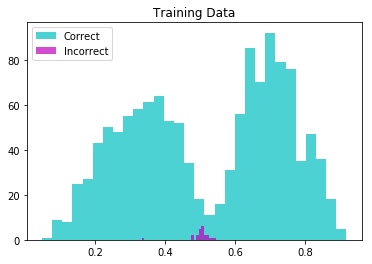

In [26]:
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30,label='Correct',color='c')
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30,label='Incorrect',color='m')
plt.legend(loc='upper left')
plt.title('Training Data')


In [27]:
test_predictions = grid_search.predict(test_set)
test_grid_reg_results = pd.DataFrame({'True':test_set_target, 'predict':test_predictions})
test_grid_reg_results['Comparison'] = test_grid_reg_results.apply(comparison_col, axis = 1)

Text(0.5, 1.0, 'Test Data')

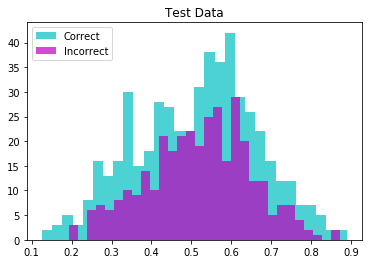

In [28]:
plt.hist(test_grid_reg_results[test_grid_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30,label='Correct',color='c')
plt.hist(test_grid_reg_results[test_grid_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30,label='Incorrect',color='m')
plt.legend(loc='upper left')
plt.title('Test Data')

Text(0.5, 1.0, 'ROC Curve for Test Data')

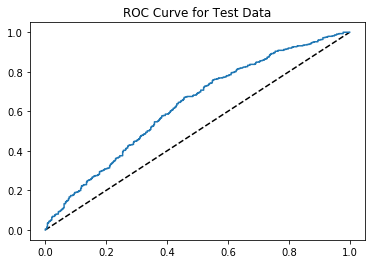

In [29]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(test_set_target, test_predictions)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.title('ROC Curve for Test Data')

## Modifying original data before balancing late vs not late

In [30]:
orig_predictions = grid_search.predict(flights_binarized_orig)
orig_target = flights_orig['late or cancelled']
orig_grid_reg_results = pd.DataFrame({'True':orig_target, 'predict':orig_predictions})
orig_grid_reg_results['Comparison'] = orig_grid_reg_results.apply(comparison_col, axis = 1)

(0, 200)

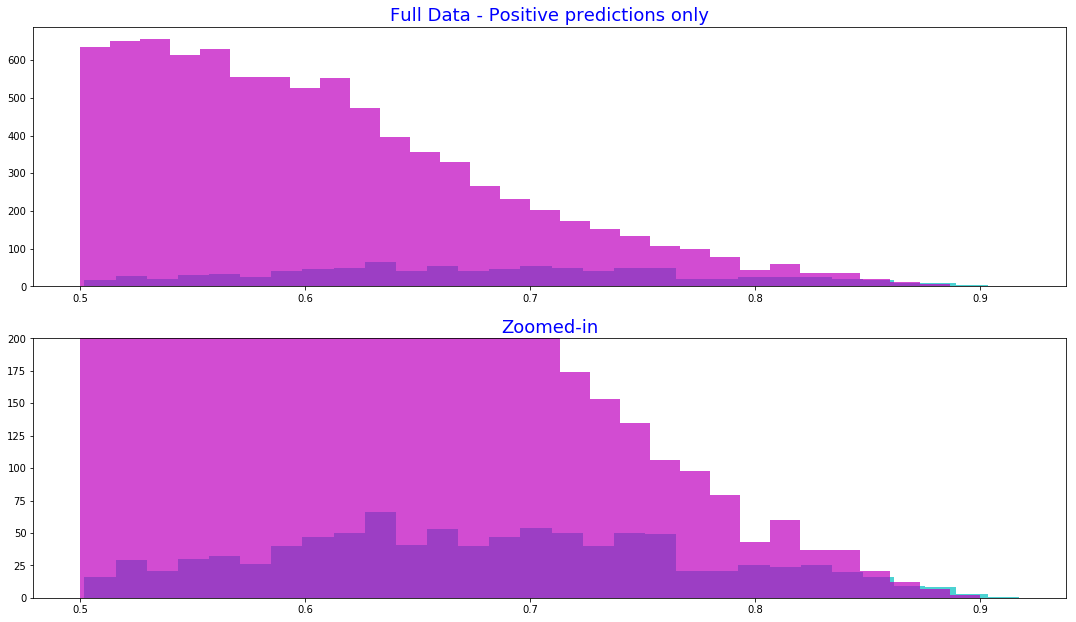

In [31]:
fig = plt.figure(figsize=(18.5, 10.5))
sub1 = fig.add_subplot(211) # instead of plt.subplot(2, 2, 1)
sub1.set_title('Full Data - Positive predictions only', fontsize=18, color="blue")
sub1.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([1])]['predict'],alpha=0.7, bins=30,label='True Positive',color='c')
sub1.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([3])]['predict'],alpha=0.7, bins=30,label='False Positive',color='m')
#sub1.set_xlim([0, 1])

sub2 = fig.add_subplot(212)
sub2.set_title('Zoomed-in', fontsize=18, color="blue")
sub2.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([1])]['predict'],alpha=0.7, bins=30,label='True Positive',color='c')
sub2.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([3])]['predict'],alpha=0.7, bins=30,label='False Positive',color='m')
sub2.set_ylim([0, 200])
#sub1.set_xlim([0, 1])

In [32]:
confusion_matrix(orig_target,(orig_predictions).round())

array([[9975, 8590],
       [ 149,  954]], dtype=int64)

Text(0.5, 1.0, 'ROC Curve for Full Data')

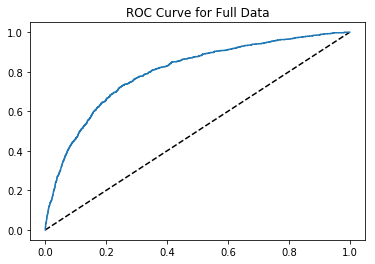

In [33]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(orig_target, orig_predictions)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.title('ROC Curve for Full Data')

## Thank You!